## Conexão com o banco

Primeiramente precisamos importar algumas configurações e nos conectar a nossa base de dados


In [3]:
# Caso utilize o Google Colab, descomente as linhas abaixo para montar o Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

# Importar bibliotecas necessárias
from urllib.parse import quote_plus
import socket
import os

# Importar pymongo para acesso aos documentos no banco de dados
import pymongo

# Importar configparser e pprint para ler o arquivo de configuração e imprimir os dados
import configparser
import pprint

hostname = socket.gethostname()
IPAddr = socket.gethostbyname(hostname)
print("Nome do seu computador:" + hostname)
print("O endereço IP do seu computador:" + IPAddr)

config = configparser.ConfigParser()
config.read('./conf.ini')

# Configurações do MongoDB
username = config['mongo']['USERNAME']
password = config['mongo']['PASSWORD']
host = config['mongo']['HOST']


# Criar string de conexão com o banco
connection_string = 'mongodb://{}:{}@{}/?retryWrites=true&w=majority'.format(
        username,
        quote_plus(password),
        host
    )

# Conectar ao MongoDB
client = pymongo.MongoClient(connection_string)

Nome do seu computador:fedora
O endereço IP do seu computador:192.168.18.37


## Tratamento de dados




### Passo 1: realizar busca das informações para um aluno
O resultado é emitido para um determinado aluno, para isso é necessário os resultados dos formulários referentes as suas turmas durante o ensino médio (1°,2° e 3° ano).



In [4]:

from pipelines import *

db_connection = client[config['mongo']['DB_NAME']]
formulario_collection = db_connection['formularios_professor']
escola_collection = db_connection['escolas']
competencia_collection = db_connection['competencias']


CHOSEN_SCHOOL = config['params']['school_name']
CHOSEN_STUDENT = config['params']['student_name']

escola = escola_collection.find_one({'nome': CHOSEN_SCHOOL})

turmas_do_aluno = escola_collection.aggregate(get_turmas_do_aluno_pipeline(CHOSEN_SCHOOL, CHOSEN_STUDENT))

lista_de_turmas_do_aluno = (list(turmas_do_aluno))

#pprint.pprint(lista_de_turmas_do_aluno)


### Passo 2: Retornar Formulários que pertencem as turmas do aluno escolhido




Para que seja possível construir o perfil é necesssário pelo menos um formulários preecnhidos para cada ano letivo, ou seja os formulários do 1°,2° e 3° ano. Utilizando a pipeline do mongo db retornaremos quantos formulários foram preenchidos para cada ano, por exemplo

```python
  numDisplAval: {
    ano3: 1,
    ano1: 6,
    ano2: 3
}
```

Sendo assim utilizamos o estágio na pipeline



```python
{
    '$set': {
            'numDisplAval.ano1': {
                '$size': {
                    '$filter': {
                        'input': '$seriesAvaliadas',
                        'as': 'nota',
                        'cond': {
                            '$eq': [
                                '$$nota', 1
                            ]
                        }
                    }
                }
            },
            'numDisplAval.ano2': {
                '$size': {
                    '$filter': {
                        'input': '$seriesAvaliadas',
                        'as': 'nota',
                        'cond': {
                            '$eq': [
                                '$$nota', 2
                            ]
                        }
                    }
                }
            },
            'numDisplAval.ano3': {
                '$size': {
                    '$filter': {
                        'input': '$seriesAvaliadas',
                        'as': 'nota',
                        'cond': {
                            '$eq': [
                                '$$nota', 3
                            ]
                        }
                    }
                }
            }
        }
    }
```



### Passo 3: cálculo do somáorio da competência em todas as disciplinas



Antes de mais nada, para ambos os perfils contruídos precisamos do somatório das competências referentes a todas as disciplinas achar o peso $k_{ij}$.

\begin{equation}
  k_{ij} = \dfrac{\mathcal{C}_{i j} }{\sum^{N}_{i=0}\mathcal{C}_{ij}}
\end{equation}

A soma das competências por disciplina é necessário para suas normalizações, esse valor so é adiquirido uma vez que todas as disciplinas que a competência $j$ está relacionada são preechidas. Sendo $N$ o número total de disciplinas, variando de $i = \{ 0 \cdots N -1 \}$ obtemos:

\begin{equation}
    \sum^{N}_{i=0}\mathcal{C}_{ij}
\end{equation}

O valor do peso que relaciona a competência com a disciplina ainda está na forma do valor atribuído pelo professor no questionário, o que é necessário então executar a média das habilidades atribuídas.
Para cada habilidade $\mathcal{H}_{k}$ em um número de habilidades $k$, obtem-se o atribuído da competência.

\begin{equation}
    \mathcal{C}_{i j} = \dfrac{1}{L}\sum^{L}_{l=0}\mathcal{H}_{l}
\end{equation}

Postariormente o necessário é normalizar este valor em relação a soma dos valores da competências para todas as disciplinas. O que será visto no próximo passo.



```
# Média das Habilidades
{
    '$set': {
      'grafos.arestas.valor': {
        '$avg': '$grafos.arestas.valor',
      },
    },
}

# Somatório das competências
{
    '$addFields': {
      'sumValorCompetencias': {
        '$sum': '$arestas.valor',
      },
    },
},
```



### Passo 4: Retornar formulário

Utilizando a função de agregação do mongo para retornar os dados formatados, sendo os formulários pertencentes as turmas do aluno, os formulários contém quantas disciplinas de cada foram respondidas para a competência associada

In [5]:

ids_turmas = [turma['_id'] for turma in lista_de_turmas_do_aluno]

competencias_avaliadas = list(formulario_collection.aggregate(get_competencias_avaliadas_pipeline(ids_turmas)))

#pprint.pprint(competencias_avaliadas)


### Passo 5: checar formulários inválidos

Como foi dito no dado anterior temos as disciplinas respondidas para cada ano . Avalie se o numero de arestas é igual ao numero de elementos das matrizes

In [6]:

total_competencia_por_area = list(competencia_collection.aggregate(get_competencia_por_area_pipeline()))

[result] = list(escola_collection.aggregate(get_disciplina_por_area_pipeline()))
numDiscip = result["numDiscip"]  # Acessa o valor pela chave


[ result ] = list(formulario_collection.aggregate(get_arestas_total_pipeline()))
totalArestaGeral = result['totalArestasGeral']

# Verificar se os formulários estão válidos
acumulador = 0
for comp in total_competencia_por_area:
  if comp['tipo'] == 'COGNITIVOS':
    acumulador += comp['total'] * sum(numDiscip.values())
  else:
    acumulador += comp['total']* numDiscip[comp['tipo']]

invalidos =  totalArestaGeral != acumulador

if (invalidos):
  print('Formulários inválidos, resultados não serão coerentes!')
  
else:
  print('Formulários válidos')


Formulários válidos


### Passo 6: Recupaerar valor notas do histórico normalizado
Vamos extrair o valor das notas do histórco para cada disciplina e utilizar em um dicionário, associando o id da disciplina a nota obtida pelo aluno. O valor de uma nota $g_{dp}$ será $G_{dp}$ (ou $S(u)$)após dividirmos pelo valor maximo que uma nota pode alcançar ($g_{max}$).

\begin{equation}
G_{dp} = \frac{g_{dp}}{g_{max}}
\end{equation}

In [7]:
NOTA_MAXIMA_ESCOLA = float(config['params']['nota_max_escola'])
nota_historico_dict ={}

for turma in lista_de_turmas_do_aluno:
  for disciplina in turma['aluno']['notas']['historico_escolar']: #para cada disciplina d
    nota_historico_dict[(disciplina['disciplina_id'])] = disciplina['nota']/NOTA_MAXIMA_ESCOLA # teremos um valor G_dp

pprint.pprint(nota_historico_dict)


{'680a960067c1016f6e51e968': 0.89,
 '680a960067c1016f6e51e969': 0.71,
 '680a960067c1016f6e51e96a': 0.5900000000000001,
 '680a960067c1016f6e51e96b': 0.85,
 '680a960067c1016f6e51e96c': 0.67,
 '680a960067c1016f6e51e96d': 0.77,
 '680a960067c1016f6e51e96e': 0.64,
 '680a960067c1016f6e51e96f': 0.8,
 '680a960067c1016f6e51e970': 0.89,
 '680a960067c1016f6e51e971': 0.63,
 '680a960067c1016f6e51e972': 0.8800000000000001,
 '680a960067c1016f6e51e973': 0.54,
 '680a960067c1016f6e51e974': 0.6599999999999999,
 '680a960067c1016f6e51e975': 0.5700000000000001,
 '680a960067c1016f6e51e976': 0.8400000000000001,
 '680a960067c1016f6e51e977': 0.63,
 '680a960067c1016f6e51e978': 0.75,
 '680a960067c1016f6e51e979': 0.5599999999999999,
 '680a960067c1016f6e51e97a': 0.7,
 '680a960067c1016f6e51e97b': 0.65,
 '680a960067c1016f6e51e97c': 0.82,
 '680a960067c1016f6e51e97d': 0.61,
 '680a960067c1016f6e51e97e': 0.8400000000000001,
 '680a960067c1016f6e51e97f': 0.6599999999999999,
 '680a960067c1016f6e51e980': 0.97,
 '680a960067c10

### Passo 7: Recuperar valor de notas do ENEM

Na nova estrutura para cada disciplina, encontrar a disciplina respectiva do aluno, primeiramente mapearemos as disciplinas e suas notas. Assim como no histórico dividiremos pelo máximo do ENEM.

\begin{equation}
\mathcal{C}_A = \frac{En_{A}}{N_{cA}}
\end{equation}

Com uma média desses valores utilizaremos o perfil para eixos cognitivos

\begin{equation}
\mathcal{C}_C = \frac{1}{4} \cdot \sum^{4}_{A=0}\mathcal{C}_{A}
\end{equation}

In [8]:
#fazer pequeno filtro para nota do enem
list_notas_enem = [turma['aluno']['notas']['enem'] for turma in lista_de_turmas_do_aluno]
nota_enem = list_notas_enem[2].copy()

N_ca = 1000.0 #dividir todos os valores por 1000

Acc= 0.0

for key, value in nota_enem.items():
  nota_enem[key] = float("%.3f"%(value/N_ca))
  Acc += nota_enem[key]
nota_enem['MEDIA'] = float("%.3f"%(Acc/4))



pprint.pprint(nota_enem)

{'EXATAS': 0.561,
 'HUMANAS': 0.797,
 'LINGUAGENS': 0.56,
 'MEDIA': 0.675,
 'NATUREZA': 0.78}


### Passo 8: Recuperar valores de aresta normalizado e de notas
Incluindo todas as disciplinas dos conseguimos obter o valor normalizado das arestas, também aproveitamos para remodelar a estrutura de cada competência e seu respectivo grafo. Portanto precisamos obter o valor $W(u,v)$ sendo $u$ uma disciplina que se conecta as próximas do próximo ano $v$. O valor da conexão $W(u,v)$ será equivalente ao valor da competência normalizado. Trazendo para o contexto de variáveis exestirá uma aresta que tem o valor da competência, a aresta terá uma origem em uma displina ($u$) mas seu nome se repete então $u$ terá um nome $d$ e um período $p$ assim o valor da competência referente a eles se torna o $C_{dp}$

\begin{equation}
    k_{i j} = \dfrac{\mathcal{C}_{ij}}{\sum^{N}_{i=0}\mathcal{C}_{ij}}
\end{equation}

\begin{equation}
    k_{i j} = W(u,v)
\end{equation}

\begin{equation}
    C_{dp} = W(u,v)
\end{equation}

Também ja podemos obter a nota em relação ao Ensino Médio $S(u)$ ou $G_{dp}$, assim as competencias contem o grafo, cada vertice de origem $u$ e seus destinos $v$ representados por objetos de disciplina

In [9]:

competencia_grafos = {}
competencia_tag = {}

for competencia in competencias_avaliadas:
  competencia_grafos[competencia['_id']] = []
  competencia_tag[competencia['_id']] = competencia['competencia_tag']
  for aresta in competencia['arestas']:
    competencia_grafos[competencia['_id']].append({
        'u':aresta['origem'],
        'v':aresta['destino'],
        'C_dp':aresta['valor']/competencia['sumValorCompetencias'],
        'G_dp':nota_historico_dict[str(aresta['origem']['_id'])]
    })

competencia_grafos = dict(sorted(competencia_grafos.items()))

#pprint.pprint(competencia_grafos)


### Passo 9: Contruir Grafo Para Vizualização.

Para que o grafo seja melhor vizualizado e analisado, vamos utilizar libs que proporcionam isso. Vamos construir uma função para utilizar essa estrutura, outra para impressão caso desejamos. Vamos construir uma função para utilizar essa estrutura, outra para impressão caso desejamos.

### Passo 10: Construir o perfil de competências do EM 

O valor referente a saída de um nó se da por:

\begin{equation}
    y_{dp}= G_{dp} + \sum^{T_{p-1}}  Y_{p-1}
\end{equation}

Sendo um  $Y_{dp}$ como a saída de um nó multiplicado pelo peso da aresta

\begin{equation}
    Y_{dp}=C_{dp} * y_{dp}  
\end{equation}

Assumimos que nas condições iniciais $Y_{d1} = G_{d1} * C_{d1}$ e na saída do nó final $Y_{d3} = y_{d3}$, então tentaremos criar um algoritmo para cada grafo que faça um acúmulo dos pesos e propaue o valor para frente.



### Passo 11: Testar

Precisamos testar agora, escolha qualquer competência, talvez uma diferente do exemplo, execute a vizualização do grafo, faça os cáculos com a função de propagação e veja se os valores procedem

Graph created with 8 nodes and 12 edges.


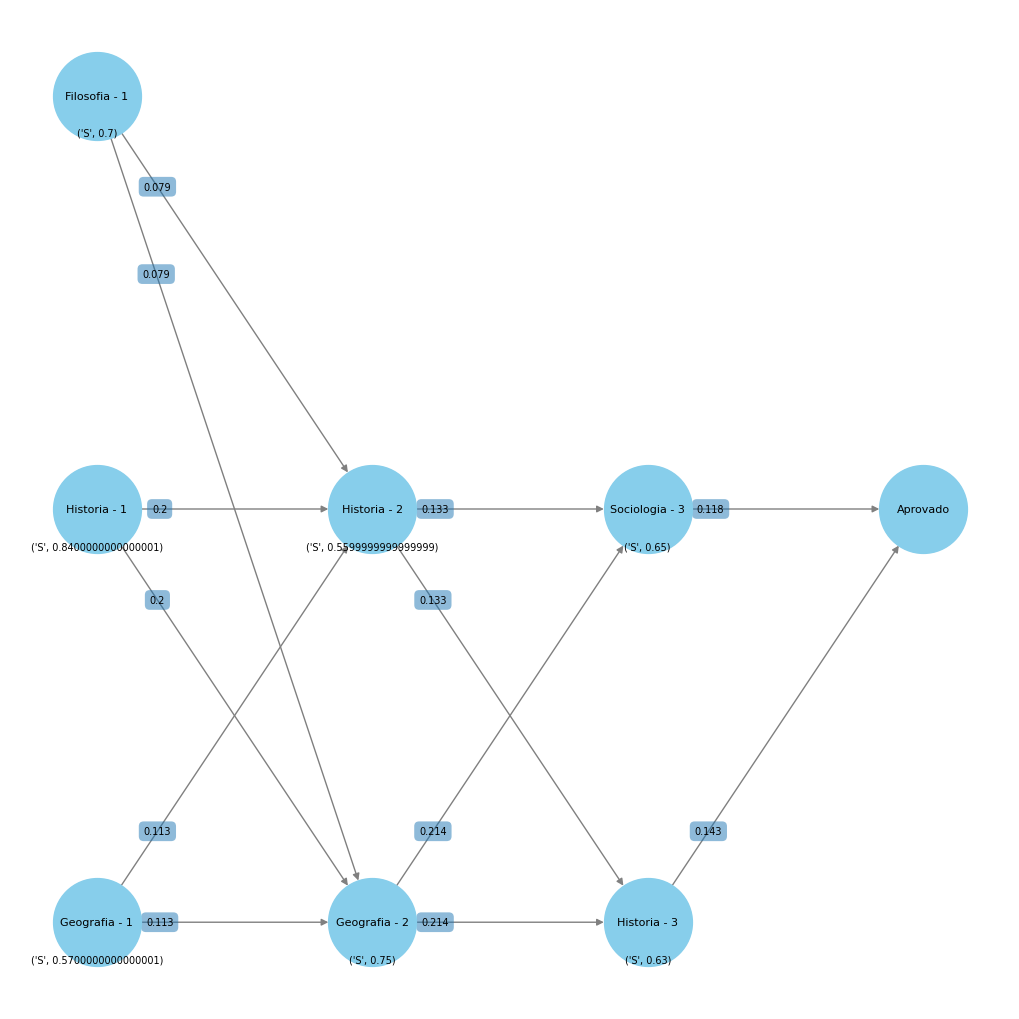

In [ ]:
from plot_graphs import plot_graph
from graph_competencias import GraphCompetences

# Selecione a competência desejada
test_competence = config['params']['chosen_competence_area_id']
# Caso queira testar com outra competência, altere o valor de chosen_competence_area_id.Se for uma compet^ncia dos eixos cognivos descomente a linha abaixo:
# test_competence = config['params']['chosen_competence_cog_id']

NOTA_MINIMA = float(config['params']['nota_min_escola'])
razao_minima = NOTA_MAXIMA_ESCOLA/ NOTA_MINIMA

# Criar o grafo e plotar
test_G = GraphCompetences(competencia_grafos[test_competence],razao_minima=razao_minima)

# Plotar o grafo
plot_graph(test_G)
# Propagar valores no grafo

# Plotar o grafo com os valores propagados
# print('Saída',test_graph.output_competencia)

### Passo 12: Construir perfil de aluno máximo e aluno mínimo (normalização)

Para a normalização, teremos de fazer o perfil de um aluno máximo , com todas as notas máximas e um aluno mínimo, o mínimo requirido para passar. A forma do aluno máximo pode ser concretizada por:

\begin{equation}
    y_{fmax}=\sum_{k=1}^3\Big(\prod_{p=k}^ 3\mathcal{A}_p\Big)
\end{equation}

\begin{equation}
y_{fmax}=(1+\mathcal{A}_1)\mathcal{A}_2)\mathcal{A}_3
\end{equation}


\begin{equation}
\mathcal{A}_p = \sum_{k=0}^3C_{dp}
\end{equation}

Para o valor mínimo, usando o valor de nota míma para passar como 0,6:

\begin{equation}
y_{fmin} = 0,6 \cdot y_{fmax}
\end{equation}



In [11]:
print("Aluno máximo", test_G.aluno_maximo)
print("Aluno mínimo", test_G.aluno_minimo)

Aluno máximo 0.38706926399999997
Aluno mínimo 0.64511544


### Passo 12: Construir os vetores de perfis.

Finalmente precisamos do valor normalizado de $y$ sendo $y'$
\begin{equation}
y'_{f}=\frac{y_f-y_{fmin}}{y_{fmax}-y_{fmin}}
\end{equation}

cada saída $\gamma_{j}$ representa a saída de uma competência da matrix assim teremos:

In [12]:
perfil_enem = {}
perfil_em = {}

for key,value in competencia_grafos.items():
    tag = competencia_tag[key]
    perfil_enem[key] = nota_enem['MEDIA'] if tag == 'COGNITIVOS' else nota_enem[tag]
    grafo_competencia = GraphCompetences(value)
    
    competencia_do_aluno = grafo_competencia.output_competencia
    print("Competência:", tag,)
    print("Valor do aluno:", competencia_do_aluno)

    competencia_aluno_maximo = grafo_competencia.aluno_maximo
    competencia_aluno_minimo = grafo_competencia.aluno_minimo
    print("Valor Máximo do aluno:", competencia_aluno_maximo)
    print("Valor Mínimo do aluno:", competencia_aluno_minimo)

    perfil_em[key] = (competencia_do_aluno - competencia_aluno_minimo ) / (competencia_aluno_maximo - competencia_aluno_minimo)

    if (perfil_em[key] < 0):
        print("Perfil EM negativo!!")

# print("Perfil ENEM:", perfil_enem)
print("Perfil EM:", perfil_em)


Graph created with 32 nodes and 219 edges.
Competência: COGNITIVOS
Valor do aluno: 0.3333382056
Valor Máximo do aluno: 0.46813208800000006
Valor Mínimo do aluno: 0.23406604400000003
Graph created with 32 nodes and 219 edges.
Competência: COGNITIVOS
Valor do aluno: 0.28685993049999997
Valor Máximo do aluno: 0.40407768
Valor Mínimo do aluno: 0.20203884
Graph created with 32 nodes and 219 edges.
Competência: COGNITIVOS
Valor do aluno: 0.34070854803999995
Valor Máximo do aluno: 0.479813096
Valor Mínimo do aluno: 0.239906548
Graph created with 32 nodes and 219 edges.
Competência: COGNITIVOS
Valor do aluno: 0.25152515852
Valor Máximo do aluno: 0.368382172
Valor Mínimo do aluno: 0.184191086
Graph created with 32 nodes and 219 edges.
Competência: COGNITIVOS
Valor do aluno: 0.31183730660000003
Valor Máximo do aluno: 0.41911784199999996
Valor Mínimo do aluno: 0.20955892099999998
Graph created with 14 nodes and 40 edges.
Competência: LINGUAGENS
Valor do aluno: 0.30160442203
Valor Máximo do aluno:

## Exibir indicador de similaridade (plot de gráficos)


### Gráfico geral
Baseado nos estudos anteriores a comparação dos perfis seria de tal forma. Apresentaremos o grafico mediante a cada competência, como o perfil do ensino médio apenas utilizamos a nota, usamos uma constante, que deverá ser comparado as competências, elas terima que no caso se adequar aquela contante da nota

In [ ]:

from plot_graphs import bar_plot, spider_plot

competencias_dict = list(competencia_collection.aggregate(get_legendas_colunas_pipeline()))[0]

# print(competencias_dict)

cores = {
    'EXATAS': '#394fe3',
    'HUMANAS': '#e3dd39',
    'LINGUAGENS': '#d919e3',
    'MEDIA': '#6007b3',
    'COGNITIVOS': '#e31c19',
    'NATUREZA': '#39e347'
}

columns = [ competencias_dict[key]['codigo'] for key in perfil_em.keys() ]

columns_colors = [ cores[competencias_dict[key]['area']] for key in perfil_em.keys() ]
values_em = list(perfil_em.values())
values_enem = list(perfil_enem.values())

# print("Colunas:", columns)
# print("Cores:", columns_colors)


constant_lines = [
    {
        'name': 'Vestibular - {}'.format(key),
        'y': value,
        'color': cores[key],
        'dash': 'dot' if key == 'MEDIA' else 'dash'  # Linha da média com estilo diferente
    } 
    for key, value in nota_enem.items()
]

print("Perfil de", CHOSEN_STUDENT, 'na escola "', CHOSEN_SCHOOL, '"')

fig = bar_plot(
    columns,
    'Competências', 
    values_em,
    True,
    constant_lines,
    columns_colors
)
spider_fig = spider_plot(columns,['Egresso',' Vestibulando'], [values_em, values_enem], show=True)


{'680a960067c1016f6e51e944': {'area': 'COGNITIVOS', 'codigo': 'COG.D.L'}, '680a960067c1016f6e51e945': {'area': 'COGNITIVOS', 'codigo': 'COG.C.F'}, '680a960067c1016f6e51e946': {'area': 'COGNITIVOS', 'codigo': 'COG.S.P'}, '680a960067c1016f6e51e947': {'area': 'COGNITIVOS', 'codigo': 'COG.C.A'}, '680a960067c1016f6e51e948': {'area': 'COGNITIVOS', 'codigo': 'COG.E.P'}, '680a960067c1016f6e51e949': {'area': 'LINGUAGENS', 'codigo': 'LIN.H1.H4'}, '680a960067c1016f6e51e94a': {'area': 'LINGUAGENS', 'codigo': 'LIN.H5.H8'}, '680a960067c1016f6e51e94b': {'area': 'LINGUAGENS', 'codigo': 'LIN.H9.H11'}, '680a960067c1016f6e51e94c': {'area': 'LINGUAGENS', 'codigo': 'LIN.H12.H14'}, '680a960067c1016f6e51e94d': {'area': 'LINGUAGENS', 'codigo': 'LIN.H15.H17'}, '680a960067c1016f6e51e94e': {'area': 'LINGUAGENS', 'codigo': 'LIN.H18.H20'}, '680a960067c1016f6e51e94f': {'area': 'LINGUAGENS', 'codigo': 'LIN.H21.H24'}, '680a960067c1016f6e51e950': {'area': 'LINGUAGENS', 'codigo': 'LIN.H25.H27'}, '680a960067c1016f6e51e9

A vizualização não fica tão agradável, portanto vamos seprar em graficos para cada área.

In [ ]:
#fazer um plot para cada area
area_values_dict = {}
for area in ['EXATAS', 'HUMANAS', 'LINGUAGENS', 'NATUREZA']:
    area_columns = [competencias_dict[key]['codigo'] for key in perfil_em.keys() if competencias_dict[key]['area'] == area or competencias_dict[key]['area'] == 'COGNITIVOS']
    area_values_em = [perfil_em[key] for key in perfil_em.keys() if competencias_dict[key]['area'] == area or competencias_dict[key]['area'] == 'COGNITIVOS']
    
    area_colors = [cores[competencias_dict[key]['area']] for key in perfil_em.keys() if competencias_dict[key]['area'] == area or competencias_dict[key]['area'] == 'COGNITIVOS']

    constant_lines = [
        {
            'name': 'Vestibular - {}'.format(area),
            'y': nota_enem[area],
            'color': cores[area],
            'dash': 'dash'  # Linha da média com estilo diferente
        },
        {
            'name': 'Média - total',
            'y': nota_enem['MEDIA'],
            'color': cores['MEDIA'],
            'dash': 'dot'  # Linha da média com estilo diferente
        } 
    ]
    print(f"Plotando área: {area}")
    print("Colunas:", area_columns)
    print("Cores:", area_colors)
    print("Valores EM:", area_values_em)

    fig_area = bar_plot(
        area_columns,
        f'Competências - {area}',
        area_values_em,
        True,
        constant_lines,
        area_colors
    )

    area_values_dict[area] = area_values_em

Plotando área: EXATAS
Colunas: ['COG.D.L', 'COG.C.F', 'COG.S.P', 'COG.C.A', 'COG.E.P', 'EXA.H1.H5', 'EXA.H6.H9', 'EXA.H10.H14', 'EXA.H15.H18', 'EXA.H19.H23', 'EXA.H24.H26', 'EXA.H27.H30']
Cores: ['#e31c19', '#e31c19', '#e31c19', '#e31c19', '#e31c19', '#394fe3', '#394fe3', '#394fe3', '#394fe3', '#394fe3', '#394fe3', '#394fe3']
Valores EM: [0.4241203034131681, 0.41982566569873386, 0.4201719414511352, 0.36556640162271486, 0.488065051642445, 0.5845915285222244, 0.5615319893503844, 0.5690156823310248, 0.5831061757590144, 0.5902436552238305, 0.5726484018264839, 0.6035019490325876]


Plotando área: HUMANAS
Colunas: ['COG.D.L', 'COG.C.F', 'COG.S.P', 'COG.C.A', 'COG.E.P', 'HUM.H1.H5', 'HUM.H6.H10', 'HUM.H11.H15', 'HUM.H16.H20', 'HUM.H21.H25', 'HUM.H26.H30']
Cores: ['#e31c19', '#e31c19', '#e31c19', '#e31c19', '#e31c19', '#e3dd39', '#e3dd39', '#e3dd39', '#e3dd39', '#e3dd39', '#e3dd39']
Valores EM: [0.4241203034131681, 0.41982566569873386, 0.4201719414511352, 0.36556640162271486, 0.488065051642445, 0.2850384131714378, 0.31334019623939974, 0.3012735450083783, 0.28688701238307235, 0.2961925200706048, 0.30564001776413835]


Plotando área: LINGUAGENS
Colunas: ['COG.D.L', 'COG.C.F', 'COG.S.P', 'COG.C.A', 'COG.E.P', 'LIN.H1.H4', 'LIN.H5.H8', 'LIN.H9.H11', 'LIN.H12.H14', 'LIN.H15.H17', 'LIN.H18.H20', 'LIN.H21.H24', 'LIN.H25.H27', 'LIN.H28.H30']
Cores: ['#e31c19', '#e31c19', '#e31c19', '#e31c19', '#e31c19', '#d919e3', '#d919e3', '#d919e3', '#d919e3', '#d919e3', '#d919e3', '#d919e3', '#d919e3', '#d919e3']
Valores EM: [0.4241203034131681, 0.41982566569873386, 0.4201719414511352, 0.36556640162271486, 0.488065051642445, 0.4482887513037948, 0.469166472494916, 0.4553366884744858, 0.42822936854931054, 0.45561288331504546, 0.47768351383617114, 0.4163206220302838, 0.44008060349297606, 0.46903173798181197]


Plotando área: NATUREZA
Colunas: ['COG.D.L', 'COG.C.F', 'COG.S.P', 'COG.C.A', 'COG.E.P', 'NAT.H1.H4', 'NAT.H5.H7', 'NAT.H8.H12', 'NAT.H13.H16', 'NAT.H17.H19', 'NAT.H20.H23', 'NAT.H24.H27', 'NAT.H28.H30']
Cores: ['#e31c19', '#e31c19', '#e31c19', '#e31c19', '#e31c19', '#39e347', '#39e347', '#39e347', '#39e347', '#39e347', '#39e347', '#39e347', '#39e347']
Valores EM: [0.4241203034131681, 0.41982566569873386, 0.4201719414511352, 0.36556640162271486, 0.488065051642445, 0.550875547258408, 0.41021265615780317, 0.45771957733037716, 0.46182234263913624, 0.5076805986694287, 0.4327945605754104, 0.5149931989227896, 0.4586593501904416]


Agora utilizaremos a média das áreas pare montar um gráfico similar ao dos perfil do ensino médio. Usaremos a média entre as competências presentes na área.

In [ ]:
perfil_enem_values = [ nota_enem[key] for key in ['EXATAS', 'HUMANAS', 'LINGUAGENS', 'NATUREZA']]
perfil_media_area_values_em = [sum(area_values_dict[area]) / len(area_values_dict[area]) for area in ['EXATAS', 'HUMANAS', 'LINGUAGENS', 'NATUREZA']]

spider_fig = spider_plot( ['EXATAS', 'HUMANAS', 'LINGUAGENS', 'NATUREZA'],['Egresso',' Vestibulando'], [perfil_media_area_values_em, perfil_enem_values], show=True)


Por fim, buscando obter o  índice de similaridade entre
dois perfis de competencias, para que este represente um
valor numerico entre 0% e 100%. Utilizamos a similaridade por coseno e ajustamos para a proporcionalidade.

\begin{equation}
    \theta = cos^{-1} \Bigg( \dfrac{{P}_{em} \cdot {P}_{enem} }{||{P}_{em}|| \cdot ||{P}_{enem}||} \Bigg)
\end{equation}

Assumimos que a maior diferença entre os vetores é de $\pi/2$ rad, dessa forma ajustamos a escala para o valor máximo da diferença ser 1.

\begin{equation}
  Id = 1- \frac{2\theta}{\pi}
\end{equation}


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import math
import numpy as np

em_array = np.array(values_em)
enem_array = np.array(values_enem)

similarity_cos = cosine_similarity([em_array], [enem_array])[0][0]

theta = math.acos(similarity_cos)
similarity = 1-theta/(math.pi/2.0)

print('Similaridade de {}% entre os perfis do ensino médio e nem para as competências'.format(similarity * 100))


em_array = np.array(perfil_media_area_values_em)
enem_array = np.array(perfil_enem_values)

similarity_cos = cosine_similarity([em_array], [enem_array])[0][0]

theta = math.acos(similarity_cos)
similarity = 1-theta/(math.pi/2.0)

print('Similaridade de {}% entre os perfis da média'.format(similarity * 100))



Similaridade de 79.83606132588825% entre os perfis do ensino médio e nem para as competências
Similaridade de 82.73287978459295% entre os perfis da média
